In [67]:
import torch
from copy import deepcopy

from Lie import inv_SO3, log_SO3, exp_so3, bracket_so3, inv_SE3, log_SE3, exp_se3, bracket_se3
from distributions import get_dist
from ode_solvers import get_ode_solver

from models.modules import FC_vec

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from IPython.display import clear_output

device = 'cuda:0'

def plot_SE3(transformations, ax=None):
    """
    Visualize a set of SE(3) transformations as coordinate frames.

    Parameters:
        transformations (list of np.ndarray): List of 4x4 SE(3) matrices.
        ax (matplotlib.axes._subplots.Axes3DSubplot, optional): Existing 3D axis to plot on.

    Returns:
        ax: The axis with the plotted transformations.
    """
    if ax is None:
        fig = plt.figure(figsize=(10, 8))
        ax = fig.add_subplot(111, projection='3d')

    # Set axis limits
    ax.set_xlim([-5, 5])
    ax.set_ylim([-5, 5])
    ax.set_zlim([-5, 5])

    # Add axis labels
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')

    for T in transformations:
        # Extract rotation and translation
        R = T[:3, :3]  # Rotation matrix (3x3)
        t = T[:3, 3]   # Translation vector (3,)

        # Origin of the frame
        origin = t

        # Axes of the frame
        x_axis = R[:, 0]
        y_axis = R[:, 1]
        z_axis = R[:, 2]

        # Plot the axes
        ax.quiver(origin[0], origin[1], origin[2],
                  x_axis[0], x_axis[1], x_axis[2], color='r', label='X' if T is transformations[0] else "")
        ax.quiver(origin[0], origin[1], origin[2],
                  y_axis[0], y_axis[1], y_axis[2], color='g', label='Y' if T is transformations[0] else "")
        ax.quiver(origin[0], origin[1], origin[2],
                  z_axis[0], z_axis[1], z_axis[2], color='b', label='Z' if T is transformations[0] else "")

    ax.legend()
    ax.view_init(elev=20, azim=30)
    return ax

In [68]:
class SE3Flow(torch.nn.Module):
    def __init__(self, vector_field):
        super().__init__()
        self.vector_field = vector_field
        self.init_dist = get_dist({"name": "SO3_uniform_R3_normal"})
        self.ode_solver = get_ode_solver({'name': 'SE3_RK_mk', 'num_steps': 20})

    def forward(self, z, t, x_t):
        # "z" is for conditional variable (deprecated)

        # t: (bs, 1)
        # x_t: (bs, 4, 4)
        inputs = torch.cat([t, x_t.view(-1, 16)], dim=1) # (bs, 17)
        v_t = self.vector_field(inputs)
        return v_t # (bs, 6)

    def get_traj(self, x_0, x_1, t):
        # Get rotations
        R_0 = x_0[:, :3, :3]
        R_1 = x_1[:, :3, :3]

        # Get translations
        p_0 = x_0[:, :3, 3]
        p_1 = x_1[:, :3, 3]

        # Get x_t
        x_t = torch.eye(4).repeat(len(x_1), 1, 1).to(x_1)
        x_t[:, :3, :3] = (R_0 @ exp_so3(t.unsqueeze(2) * log_SO3(inv_SO3(R_0) @ R_1)))
        x_t[:, :3, 3] = p_0 + t * (p_1 - p_0)

        # Get u_t
        u_t = torch.zeros(len(x_1), 6).to(x_1)
        u_t[:, :3] = bracket_so3(log_SO3(inv_SO3(R_0) @ R_1))
        u_t[:, :3] = torch.einsum('bij,bj->bi', R_0, u_t[:, :3])    # Convert w_b to w_s
        u_t[:, 3:] = p_1 - p_0

        return x_t, u_t

    def step(self, x_1, optimizer=None):
        # x_1: (bs, 4, 4)

        # Sample t and x_0
        t = torch.rand(len(x_1), 1).to(x_1.device)
        x_0 = self.init_dist(len(x_1), x_1.device)

        # Get x_t and u_t
        x_t, u_t = self.get_traj(x_0, x_1, t)

        # Forward
        v_t = self(None, t, x_t)

        # Calculate loss
        loss = ((v_t - u_t)**2).mean()

        # Backward
        if optimizer is not None:
            loss.backward()
            optimizer.step()

        # Archive results
        results = {
            f'loss': loss.item(),
        }
        return results

    @torch.no_grad()
    def sample(self, num_samples, device):
        # Sample initial samples
        x_0 = self.init_dist(num_samples, device)
        
        # Push-forward initial samples
        x_1_hat = self.ode_solver(None, x_0, self)[:, -1]

        return x_1_hat

C:\Users\21448\AppData\Local\Temp\ipykernel_15132\2068017264.py:64: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


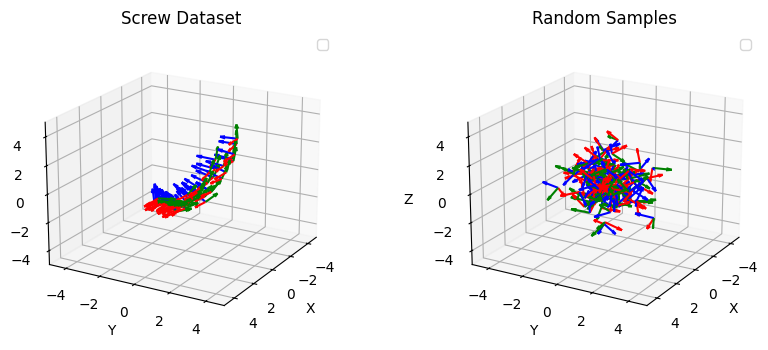

In [69]:
# Toy dataset (screw motion between two SE(3))
T1 = torch.tensor([
    [1, 0, 0, 3],
    [0, 1, 0, 0],
    [0, 0, 1, 0],
    [0, 0, 0, 1]
], dtype=torch.float32).view(1, 4, 4)

T2 = torch.tensor([
    [1, 0, 0, 0],
    [0, 0, -1, 3],
    [0, 1, 0, 0],
    [0, 0, 0, 1]
], dtype=torch.float32).view(1, 4, 4)

V = log_SE3(inv_SE3(T1)@T2)
T_screw = torch.cat([
    T1@exp_se3(
        t/49 *V  + torch.randn_like(V)*0.1
        ) for t in range(50)
    ], dim=0)

fig = plt.figure(figsize=(10, 4))
ax1 = fig.add_subplot(121, projection='3d')
ax2 = fig.add_subplot(122, projection='3d')
ax1.set_title('Screw Dataset')
plot_SE3(T_screw, ax=ax1)
r_sampels = get_dist({"name": "SO3_uniform_R3_normal"})(100, 'cpu')
ax2.set_title('Random Samples')
plot_SE3(r_sampels, ax=ax2)
plt.show()

In [70]:
class SE3Dataset(torch.utils.data.Dataset):
    """
    Custom PyTorch dataset for SE(3) data of shape (N, 4, 4).
    """
    def __init__(self, data):
        """
        Args:
            data (numpy.ndarray or torch.Tensor): Dataset of shape (N, 4, 4).
        """
        if isinstance(data, np.ndarray):
            self.data = torch.tensor(data, dtype=torch.float32)
        elif isinstance(data, torch.Tensor):
            self.data = data.float()
        else:
            raise TypeError("Data must be a numpy array or torch tensor.")

    def __len__(self):
        """Return the number of samples in the dataset."""
        return self.data.shape[0]

    def __getitem__(self, idx):
        """Retrieve a single sample by index.

        Args:
            idx (int): Index of the sample to retrieve.

        Returns:
            torch.Tensor: A single SE(3) matrix of shape (4, 4).
        """
        return self.data[idx]

In [71]:
ds = SE3Dataset(T_screw)
data_loader = torch.utils.data.DataLoader(dataset=ds, batch_size=10, shuffle=True)

velocity = FC_vec(
    in_chan=17,
    out_chan=6,
    l_hidden=[1024, 1024, ],
    activation=['gelu', 'gelu'],
    out_activation='linear',
)

In [ ]:
total_epoch = 10000
model = SE3Flow(velocity)
model.to(device);

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1.0e-8)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1000, gamma=0.5)

for epoch in range(total_epoch):
    mean_loss = []
    for x1 in data_loader:
        train_results = model.step(x1.to(device), optimizer)
        mean_loss.append(train_results['loss'])
    mean_loss = sum(mean_loss)/len(mean_loss)
    if epoch % 10 == 0:
        print(f"Epoch: {epoch}, Loss: {mean_loss}")

    # if epoch % 500 == 0:
    #     clear_output(wait=True)
    #     T_gen = model.sample(50, device)

    #     fig = plt.figure(figsize=(10, 4))
    #     ax1 = fig.add_subplot(121, projection='3d')
    #     ax2 = fig.add_subplot(122, projection='3d')
    #     ax1.set_title('Screw Dataset')
    #     plot_SE3(T_screw, ax=ax1)
    #     ax2.set_title('Generated Dataset')
    #     plot_SE3(T_gen.detach().cpu(), ax=ax2)
    #     plt.show()
       

Best model updated: 2.3543545246124267
Epoch: 0, Loss: 2.3543545246124267
Best model updated: 2.312719964981079
Best model updated: 1.8898236989974975
Best model updated: 1.8226746559143066
Best model updated: 1.5784437894821166
Best model updated: 1.543722915649414
Best model updated: 1.3779723167419433
Best model updated: 1.0961979627609253
Epoch: 10, Loss: 1.0961979627609253
Epoch: 20, Loss: 1.5063108205795288
Epoch: 30, Loss: 1.2955107688903809
Epoch: 40, Loss: 1.4425479412078857
Best model updated: 1.00525906085968
Best model updated: 0.9864133358001709
Epoch: 50, Loss: 1.7340900421142578
Epoch: 60, Loss: 1.2829563617706299
Epoch: 70, Loss: 1.4450497269630431
Epoch: 80, Loss: 1.9008240222930908
Epoch: 90, Loss: 1.4646357774734498
Epoch: 100, Loss: 1.6295233607292174
Epoch: 110, Loss: 1.4234511137008667
Epoch: 120, Loss: 1.1207710027694702
Epoch: 130, Loss: 0.9935842394828797
Epoch: 140, Loss: 1.3517876982688903
Best model updated: 0.9833831071853638
Epoch: 150, Loss: 1.34447932243

C:\Users\21448\AppData\Local\Temp\ipykernel_15132\2068017264.py:64: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


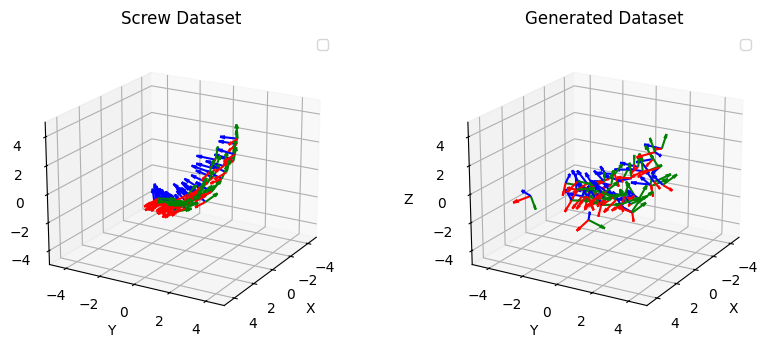

In [73]:
T_gen = model.sample(50, device)
fig = plt.figure(figsize=(10, 4))
ax1 = fig.add_subplot(121, projection='3d')
ax2 = fig.add_subplot(122, projection='3d')
ax1.set_title('Screw Dataset')
plot_SE3(T_screw, ax=ax1)
ax2.set_title('Generated Dataset')
plot_SE3(T_gen.detach().cpu(), ax=ax2)
plt.show()